In [1]:
from csv import DictReader

import numpy as np
import matplotlib.pyplot as plt

# Data and Models

Load positional data and our Greek and Indian epicyclical models

In [2]:
bodies = ['sun', 'moon', 'mercury', 'venus', 'mars', 'jupiter', 'saturn']
data = {body : [] for body in bodies}

with open("data_final.csv", 'r') as f:
    reader = DictReader(f)
    for row in reader:
        for body in bodies:
            data[body].append(float(row[body + '_x']) + 1j* float(row[body + '_y']))

In [3]:
def split_data(key, period):
    d = data[key]
    train = np.array(d[0:int(period * 2)])
    test = np.array(d[int(period * 2): int(period * 4)])
    return train, test

def exp_plus(wphi, wr, t):
    return np.exp(1j * (wphi + wr) * t)

def exp_minus(wphi, wr, t):
    return np.exp(1j * (wphi - wr) * t)

def pulsating_features(wphi1, wphi2, wr, orbit_start, orbit_end, num_obs):
    t = np.linspace(orbit_start, orbit_end, num_obs)
    X = np.hstack([np.exp(1j * wphi1 * t)[:,np.newaxis], np.exp(1j * wphi2 * t)[:,np.newaxis], 
                   (exp_plus(wphi2, wr, t) - exp_minus(wphi2, wr, t))[:,np.newaxis]])
    return X

def static_pulsating_features(wphi1, wphi2, orbit_start, orbit_end, num_obs):
    return pulsating_features(wphi1, wphi2, wphi1, orbit_start, orbit_end, num_obs)
    

def greek_features(wphi1, wphi2, orbit_start, orbit_end, num_obs):
    t = np.linspace(orbit_start, orbit_end, num_obs)
    X = np.hstack([np.exp(1j * wphi1 * t)[:,np.newaxis], np.exp(1j * wphi2 * t)[:,np.newaxis]])
    return X

def train_static_pulsating(train, test, orbital_period, freq_list):
    train_orbits = round(train.shape[0]/orbital_period)
    test_orbits = round(test.shape[0]/orbital_period)
    
    wphi1_list = freq_list
    wphi2_list = freq_list
    
    candidates = []
    for wphi1 in wphi1_list:
        for wphi2 in wphi2_list:
            X = static_pulsating_features(wphi1, wphi2, 0, train_orbits, train.shape[0])
            w = complex_ridge(X, train)
            mse = np.linalg.norm(X@w - train)
            candidates.append((mse, w, wphi1, wphi2, X))
    mse, w, wphi1, wphi2, X = min(candidates, key = lambda t: t[0])
    X_test = static_pulsating_features(wphi1, wphi2, train_orbits, (train_orbits + test_orbits), test.shape[0])
    mse = np.linalg.norm(X_test@w - test)/test.shape[0]
    return mse, w, wphi1, wphi2, X, X_test
    

def train_pulsating(train, test, orbital_period, freq_list):
    train_orbits = round(train.shape[0]/orbital_period)
    test_orbits = round(test.shape[0]/orbital_period)
    
    wphi1_list = freq_list
    wphi2_list = freq_list
    wr_list = freq_list
    
    candidates = []
    for wphi1 in wphi1_list:
        for wphi2 in wphi2_list:
            for wr in wr_list:
                X = pulsating_features(wphi1, wphi2, wr, 0, train_orbits, train.shape[0])
                w = complex_ridge(X, train)
                mse = np.linalg.norm(X@w - train)
                candidates.append((mse, w, wphi1, wphi2, wr, X))
    mse, w, wphi1, wphi2, wr, X = min(candidates, key = lambda t: t[0])
    X_test = pulsating_features(wphi1, wphi2, wr, train_orbits, (train_orbits + test_orbits), test.shape[0])
    mse = np.linalg.norm(X_test@w - test)/test.shape[0]
    return mse, w, wphi1, wphi2, wr, X, X_test

def train_greek(train, test, orbital_period, freq_list):
    train_orbits = round(train.shape[0]/orbital_period)
    test_orbits = round(test.shape[0]/orbital_period)
    print(train_orbits, test_orbits)
    
    wphi1_list = freq_list
    wphi2_list = freq_list
    
    candidates = []
    for wphi1 in wphi1_list:
        for wphi2 in wphi2_list:
            X = greek_features(wphi1, wphi2, 0, train_orbits, train.shape[0])
            w = complex_ridge(X, train)
            X_test = greek_features(wphi1, wphi2, train_orbits, (train_orbits + test_orbits), test.shape[0])
            mse = np.linalg.norm(X@w - train)
            candidates.append([mse, w, wphi1, wphi2, X, X_test])
    best = min(candidates, key = lambda t: t[0])
    best[0] = np.linalg.norm(best[-1]@best[1] - test)/test.shape[0]
    return best  #mse, w, wphi1, wphi2, wr, X_tr, X_te= best

def vanilla_features(n, d):
    X = np.array([[np.exp(1j * t * i * 2/d * np.pi) for i in range(d)] for t in np.linspace(0, 100, n)])
    return X

def plot(data, title):
    plt.figure()
    plt.title(title)
    plt.plot(0, 0, 'xb', label = 'Earth')
    plt.plot(data.real, data.imag, '-o', color='orange', label='Orbit')
    plt.legend(loc='upper right')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

def complex_ridge(X, y):
    return np.linalg.inv(X.conj().T@X + 0.01 * np.eye(X.shape[1]))@X.conj().T@y

# Predictions

Training our models on each of the heavenly bodies, and examining their efficacy on test data.

## Sun

In [4]:
sun_period = 365.256 / 5 # handpicked from empirical data
sun_train, sun_test = split_data('sun', sun_period)
freq_list = np.arange(1, 40, 1) * np.pi * 2

In [5]:
# Pulsating, may take a few minutes to run!
mse_sunp, w_sunp, wphi1_sunp, wphi2_sunp, wr_sunp, Xtr_sunp, Xte_sunp = train_pulsating(sun_train, sun_test, sun_period, freq_list)

In [6]:
# Pulsating static
mse_sunps, w_sunps, wphi1_sunps, wphi2_sunps, Xtr_sunps, Xte_sunps = train_static_pulsating(sun_train, sun_test, sun_period, freq_list)

In [7]:
# Greek
mse_sung, w_sung, wphi1_sung, wphi2_sung, Xtr_sung, Xte_sung = train_greek(sun_train, sun_test, sun_period, freq_list)

2 2


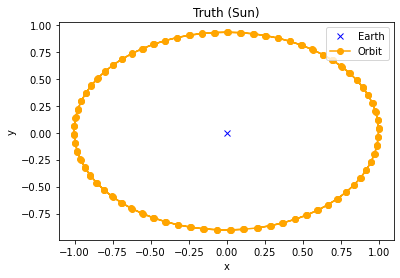

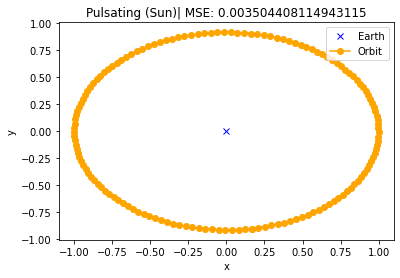

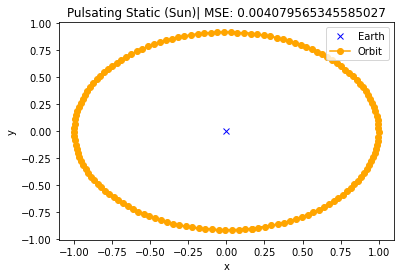

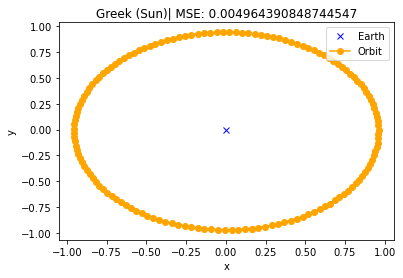

In [8]:
plot(sun_test, "Truth (Sun)")
plot(Xte_sunp@w_sunp, f"Pulsating (Sun)| MSE: {mse_sunp}")
plot(Xte_sunp@w_sunp, "Pulsating Static (Sun)| MSE: %s" % mse_sunps)
plot(Xte_sung@w_sung, "Greek (Sun)| MSE: %s"%mse_sung)

## Moon

In [9]:
moon_period = 30/ 5 # handpicked from empirical data
moon_train, moon_test = split_data('moon', moon_period)

In [10]:
# Pulsating
mse_moonp, w_moonp, wphi1_moonp, wphi2_moonp, wr_moonp, Xtr_moonp, Xte_moonp = train_pulsating(moon_train, moon_test, moon_period, freq_list)

In [11]:
# Pulsating static
mse_moonps, w_moonps, wphi1_moonps, wphi2_moonps, Xtr_moonps, Xte_moonps = train_static_pulsating(moon_train, moon_test, moon_period, freq_list)

In [12]:
# Greek
mse_moong, w_moong, wphi1_moong, wphi2_moong, Xtr_moong, Xte_moong = train_greek(moon_train, moon_test, moon_period, freq_list)

2 2


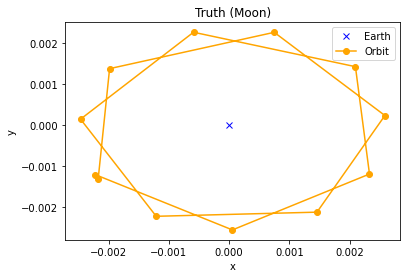

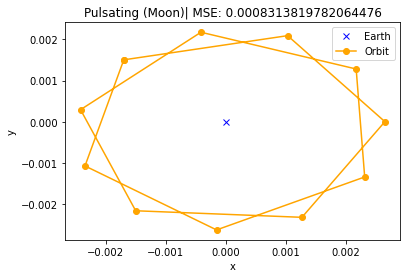

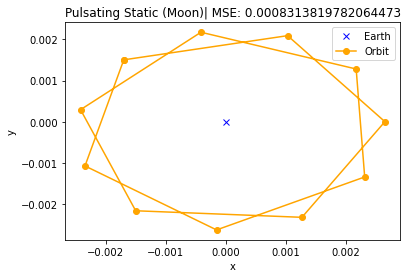

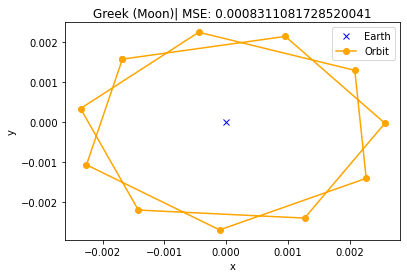

In [13]:
plot(moon_test, "Truth (Moon)")
plot(Xte_moonp@w_moonp, "Pulsating (Moon)| MSE: %s"%mse_moonp)
plot(Xte_moonps@w_moonps, "Pulsating Static (Moon)| MSE: %s"%mse_moonps)
plot(Xte_moong@w_moong, "Greek (Moon)| MSE: %s"%mse_moong)

## Mercury

In [14]:
mercury_period = 365 / 5 # handpicked from empirical data
mercury_train, mercury_test = split_data('mercury', mercury_period)

In [15]:
# Pulsating
mse_mercuryp, w_mercuryp, wphi1_mercuryp, wphi2_mercuryp, wr_mercuryp, Xtr_mercuryp, Xte_mercuryp = train_pulsating(mercury_train, mercury_test, mercury_period, freq_list)

In [16]:
# Pulsating static
mse_mercuryps, w_mercuryps, wphi1_mercuryps, wphi2_mercuryps, Xtr_mercuryps, Xte_mercuryps = train_static_pulsating(mercury_train, mercury_test, mercury_period, freq_list)

In [17]:
# Greek
mse_mercuryg, w_mercuryg, wphi1_mercuryg, wphi2_mercuryg, Xtr_mercuryg, Xte_mercuryg = train_greek(mercury_train, mercury_test, mercury_period, freq_list)

2 2


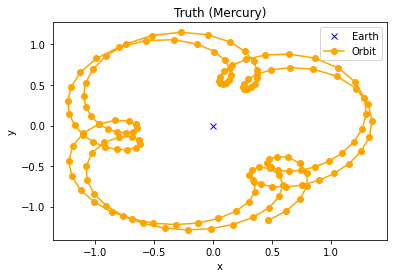

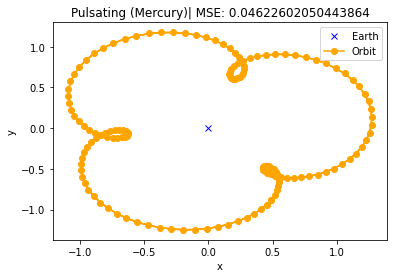

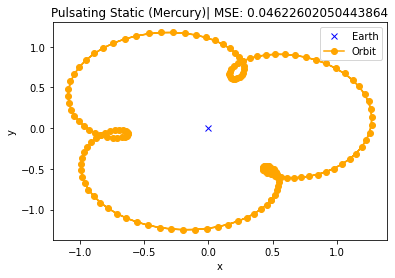

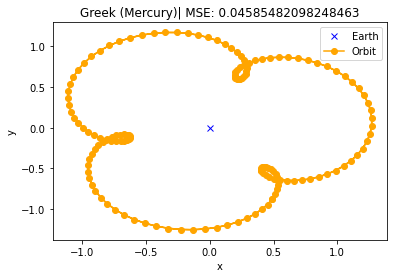

In [18]:
plot(mercury_train, "Truth (Mercury)")
plot(Xte_mercuryp@w_mercuryp, "Pulsating (Mercury)| MSE: %s"%mse_mercuryp)
plot(Xte_mercuryps@w_mercuryps, "Pulsating Static (Mercury)| MSE: %s"%mse_mercuryps)
plot(Xte_mercuryg@w_mercuryg, "Greek (Mercury)| MSE: %s"%mse_mercuryg)

## Venus


In [19]:
venus_period = 1700 / 5 # handpicked from empirical data
venus_train, venus_test = split_data('venus', venus_period)
venus_freq = np.arange(0.25, 20, 0.25) * np.pi * 2

In [20]:
# Pulsating
mse_venusp, w_venusp, wphi1_venusp, wphi2_venusp, wr_venusp, Xtr_venusp, Xte_venusp = train_pulsating(venus_train, venus_test, venus_period, venus_freq)

In [21]:
# Pulsating static
mse_venusps, w_venusps, wphi1_venusps, wphi2_venusps, Xtr_venusps, Xte_venusps = train_static_pulsating(venus_train, venus_test, venus_period, venus_freq)

In [22]:
# Greek
mse_venusg, w_venusg, wphi1_venusg, wphi2_venusg, Xtr_venusg, Xte_venusg = train_greek(venus_train, venus_test, venus_period, venus_freq)

2 2


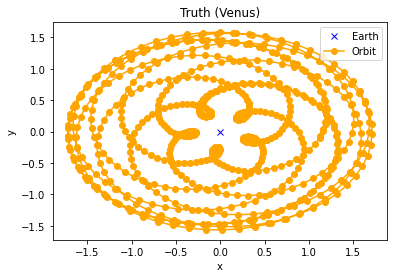

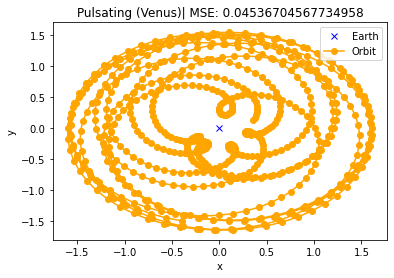

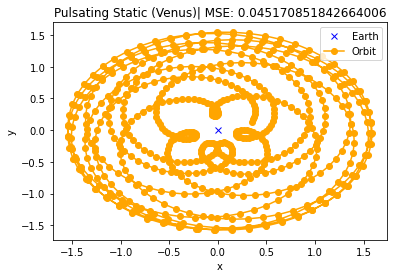

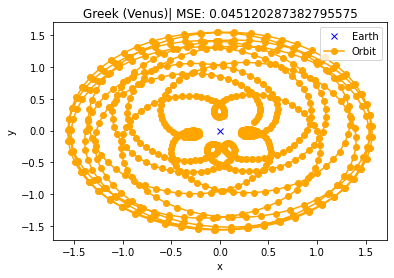

In [23]:
plot(venus_test, "Truth (Venus)")
plot(Xte_venusp@w_venusp, "Pulsating (Venus)| MSE: %s"%mse_venusp)
plot(Xte_venusps@w_venusps, "Pulsating Static (Venus)| MSE: %s"%mse_venusps)
plot(Xte_venusg@w_venusg, "Greek (Venus)| MSE: %s"%mse_venusg)

## Mars

In [24]:
mars_period = 700 / 5 # handpicked from empirical data
mars_train, mars_test = split_data('mars', mars_period)

In [25]:
# Pulsating
mse_marsp, w_marsp, wphi1_marsp, wphi2_marsp, wr_marsp, Xtr_marsp, Xte_marsp = train_pulsating(mars_train, mars_test, mars_period, freq_list)

In [26]:
# Pulsating static
mse_marsps, w_marsps, wphi1_marsps, wphi2_marsps, Xtr_marsps, Xte_marsps = train_static_pulsating(mars_train, mars_test, mars_period, freq_list)

In [27]:
# Greek
mse_marsg, w_marsg, wphi1_marsg, wphi2_marsg, Xtr_marsg, Xte_marsg = train_greek(mars_train, mars_test, mars_period, freq_list)

2 2


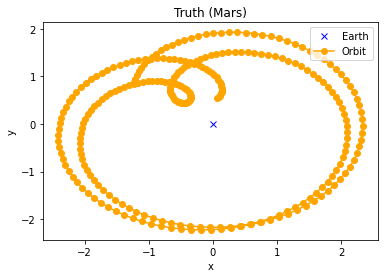

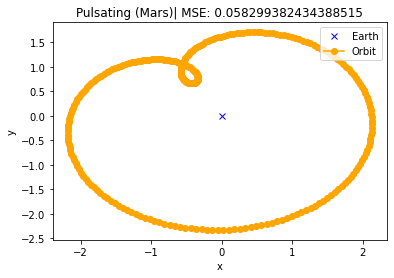

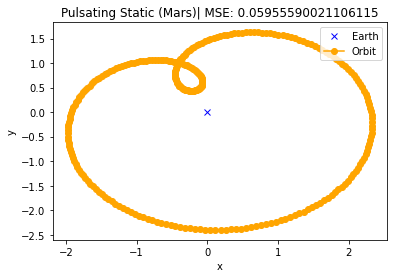

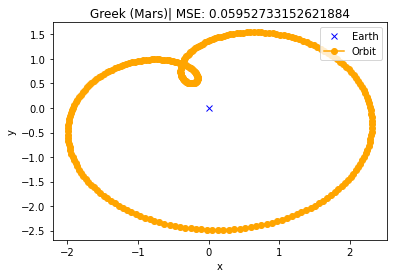

In [28]:
plot(mars_train, "Truth (Mars)")
plot(Xte_marsp@w_marsp, "Pulsating (Mars)| MSE: %s"%mse_marsp)
plot(Xte_marsps@w_marsps, "Pulsating Static (Mars)| MSE: %s"%mse_marsps)
plot(Xte_marsg@w_marsg, "Greek (Mars)| MSE: %s"%mse_marsg)

## Jupiter

In [29]:
jupiter_period = 4332.59 / 5 # handpicked from empirical data
jupiter_train, jupiter_test = split_data('jupiter', jupiter_period)

In [30]:
# Pulsating
mse_jupiterp, w_jupiterp, wphi1_jupiterp, wphi2_jupiterp, wr_jupiterp, Xtr_jupiterp, Xte_jupiterp = train_pulsating(jupiter_train, jupiter_test, jupiter_period, freq_list)

In [31]:
# Greek
mse_jupiterg, w_jupiterg, wphi1_jupiterg, wphi2_jupiterg, Xtr_jupiterg, Xte_jupiterg = train_greek(jupiter_train, jupiter_test, jupiter_period, freq_list)


2 2


In [32]:
# Pulsating static
mse_jupiterps, w_jupiterps, wphi1_jupiterps, wphi2_jupiterps, Xtr_jupiterps, Xte_jupiterps = train_static_pulsating(jupiter_train, jupiter_test, jupiter_period, freq_list)

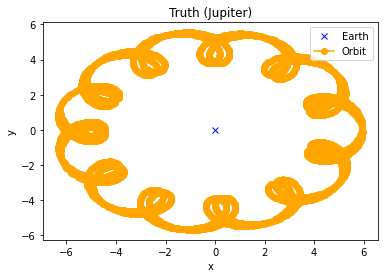

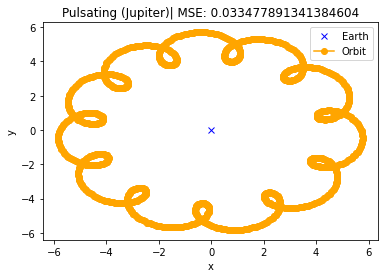

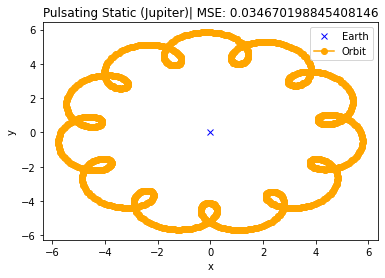

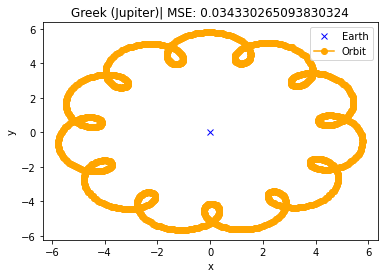

In [39]:
plot(jupiter_test, "Truth (Jupiter)")
plot(Xte_jupiterp@w_jupiterp, "Pulsating (Jupiter)| MSE: %s"%mse_jupiterp)
plot(Xte_jupiterps@w_jupiterps, "Pulsating Static (Jupiter)| MSE: %s"%mse_jupiterps)
plot(Xte_jupiterg@w_jupiterg, "Greek (Jupiter)| MSE: %s"%mse_jupiterg)

## Saturn

In [64]:
# May need to allocate more memory for this
saturn_period = 10759.22 / 5 # handpicked from empirical data
saturn_train, saturn_test = split_data('saturn', saturn_period)
saturn_freq = np.arange(1, 80, 1.5) * np.pi * 2

In [65]:
# Pulsating
mse_saturnp, w_saturnp, wphi1_saturnp, wphi2_saturnp, wr_saturnp, Xtr_saturnp, Xte_saturnp = train_pulsating(saturn_train, saturn_test, saturn_period, saturn_freq)

In [66]:
# Greek
mse_saturng, w_saturng, wphi1_saturng, wphi2_saturng, Xtr_saturng, Xte_saturng = train_greek(saturn_train, saturn_test, saturn_period, saturn_freq)

2 2


In [67]:
# Pulsating static
mse_saturnps, w_saturnps, wphi1_saturnps, wphi2_saturnps, Xtr_saturnps, Xte_saturnps = train_static_pulsating(saturn_train, saturn_test, saturn_period, saturn_freq)

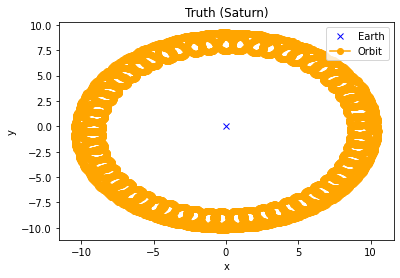

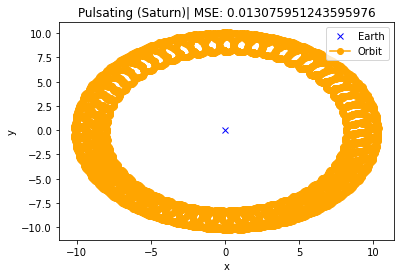

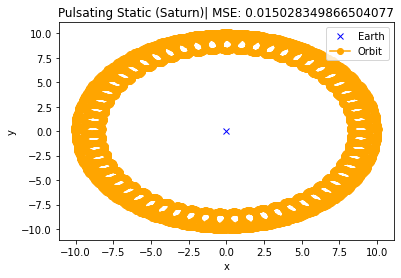

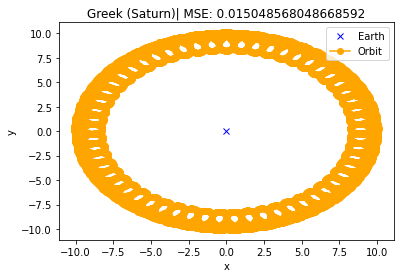

In [68]:
plot(saturn_test, "Truth (Saturn)")
plot(Xte_saturnp@w_saturnp, "Pulsating (Saturn)| MSE: %s"%mse_saturnp)
plot(Xte_saturnps@w_saturnps, "Pulsating Static (Saturn)| MSE: %s"%mse_saturnps)
plot(Xte_saturng@w_saturng, "Greek (Saturn)| MSE: %s"%mse_saturng)

# Comparison Plots

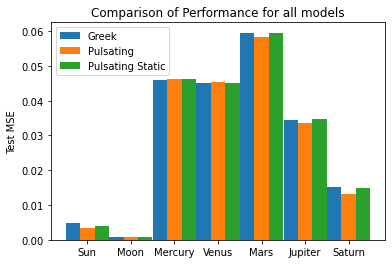

In [70]:
labels = ['Sun', 'Moon', 'Mercury', 'Venus', 'Mars', 'Jupiter', 'Saturn']
greek_mse = [mse_sung, mse_moong, mse_mercuryg, mse_venusg, mse_marsg, mse_jupiterg, mse_saturng]
pulsating_mse = [mse_sunp, mse_moonp, mse_mercuryp, mse_venusp, mse_marsp, mse_jupiterp, mse_saturnp]
static_mse = [mse_sunps, mse_moonps, mse_mercuryps, mse_venusps, mse_marsps, mse_jupiterps, mse_saturnps]

x = np.arange(len(labels))
width = 0.33

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, greek_mse, width, label='Greek')
rects2 = ax.bar(x, pulsating_mse, width, label='Pulsating')
rects3 = ax.bar(x + width, static_mse, width, label='Pulsating Static')

ax.set_ylabel('Test MSE')
ax.set_title('Comparison of Performance for all models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# def autolabel(rects):
#     """Attach a text label above each bar in *rects*, displaying its height."""
#     for rect in rects:
#         height = rect.get_height()
#         ax.annotate('{}'.format(height),
#                     xy=(rect.get_x() + rect.get_width() / 2, height),
#                     xytext=(0, 3),  # 3 points vertical offset
#                     textcoords="offset points",
#                     ha='center', va='bottom')


# autolabel(rects1)
# autolabel(rects2)
# autolabel(rects3)

# fig.tight_layout()

plt.show()